# Look at climate change in MPI

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def get_zonal_grad(x):
    """
    Function to compute zonal gradient. Ref: Fig 7 in Maher et al, 2023.
    """

    ## outlines for boxes
    ebox_coords = dict(longitude=slice(210, 270), latitude=slice(-5, 5))
    wbox_coords = dict(longitude=slice(120, 180), latitude=slice(-5, 5))

    ## compute box averages
    ebox_avg = src.utils.spatial_avg(x.sel(ebox_coords))
    wbox_avg = src.utils.spatial_avg(x.sel(wbox_coords))

    return ebox_avg - wbox_avg


def plot_hov(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.longitude,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="both",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Longitude")
        ax.set_xticks([190, 240])
        ax.set_yticks([])
        ax.axvline(190, **kwargs)
        ax.axvline(240, **kwargs)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def get_rolling_var(data, n=10):
    """
    Get variance, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    ## function to compute rolling variance
    def get_rolling_var(x):

        ## get_rolling_object
        x_rolling = x.rolling({"time": 2 * n + 1}, center=True)

        ## compute variance
        rolling_var_ = x_rolling.construct("window").var(["member", "window"])

        ## trim if necessary:
        if n > 0:
            rolling_var_ = rolling_var_.isel(time=slice(n, -n))

        return rolling_var_

    ## group by month, then computing rolling mean over years
    rolling_var = data.groupby("time.month").map(get_rolling_var)

    return rolling_var

## Load spatial data

In [3]:
## specify sliding window size for climatology
n_years = 3

## Load EOF data
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs")
eofs_sst = src.utils.load_eofs(eofs_fp / "ts.nc")
eofs_ssh = src.utils.load_eofs(eofs_fp / "ssh.nc")

## for convenience, put components and scores into datasets
components = xr.merge(
    [eofs_sst.components().rename("sst"), eofs_ssh.components().rename("ssh")]
)
scores = xr.merge([eofs_sst.scores().rename("sst"), eofs_ssh.scores().rename("ssh")])

## get forced/anomalous component
forced, anom = src.utils.separate_forced(scores, n=n_years)

## Warming pattern over time

### Look at equatorial strip

In [4]:
## get rolling avg
forced_rolling = src.utils.get_rolling_avg(forced, n=1)

## get NDJ season
month = forced_rolling.time.dt.month
forced_ndj = forced_rolling.isel(time=(month == 10))

## reconstruct equatorial average
eq_avg = lambda x: x.sel(latitude=slice(-2, 2)).mean("latitude")
kwargs = dict(scores=forced_ndj, components=components, fn=eq_avg)
forced_ndj_recon = src.utils.reconstruct_fn(**kwargs).sel(longitude=slice(125, 279))

## replace time axis with year for easier plotting
forced_ndj_recon["time"] = forced_ndj_recon["time"].dt.year
forced_ndj_recon = forced_ndj_recon.rename({"time": "year"})

## subtract leading 30-year mean
clim = forced_ndj_recon.isel(year=slice(None, 30)).mean("year")
forced_anom = forced_ndj_recon - clim

#### Hövöller plot

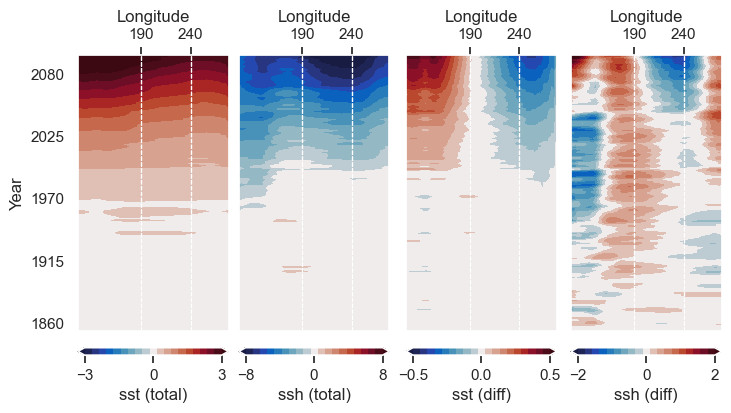

In [5]:
## setup plot
fig, axs = plt.subplots(1, 4, figsize=(7.2, 4), layout="constrained")

for j, (varname, total_amp, diff_amp) in enumerate(
    zip(["sst", "ssh"], [3, 8], [0.5, 2])
):

    ## get total plot and difference
    total = forced_anom[varname]
    diff = total - total.mean("longitude")

    ## plot data
    plot_hov(axs[j], total, amp=total_amp, label=f"{varname} (total)")
    plot_hov(axs[j + 2], diff, amp=diff_amp, label=f"{varname} (diff)")

axs[0].set_yticks(np.arange(1860, 2100, 55))
axs[0].set_ylabel("Year")
plt.show()

#### Line plots

Function to do formatting. Not sure about units for SSH: data attribute says "m", but data itself suggests "cm"...

In [6]:
def format_line_plots(axs):
    """format subplots"""
    axs[0, 1].legend(prop=dict(size=6))
    for ax in axs[0, :]:
        ax.set_xticks([])
    for ax in axs[:, 1]:
        ax.yaxis.tick_right()
    axs[1, 0].set_xticks([1860, 1970, 2080])
    axs[1, 1].set_xticks([140, 210, 280])
    axs[0, 1].set_yticks([-3, 3])
    axs[1, 1].set_yticks([-20, 20])
    axs[0, 0].set_yticks([25.5, 28.5])
    axs[1, 0].set_yticks([94, 87])
    axs[0, 0].set_ylabel(r"SST ($^{\circ}$C)")
    axs[1, 0].set_ylabel(r"SSH (cm?)")
    axs[0, 0].set_title("Zonal mean")
    axs[0, 1].set_title("Zonal anomaly")
    axs[1, 0].set_xlabel("Year")
    axs[1, 1].set_xlabel("Longitude")

    return

Make plot

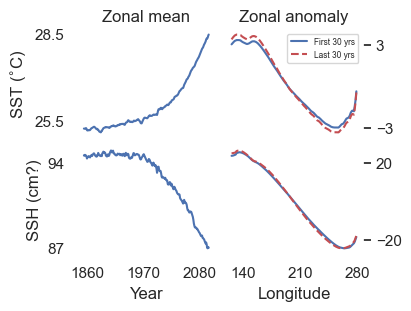

In [7]:
## get zonal mean and tilt
zonal_mean = forced_ndj_recon.mean("longitude")
tilt = forced_ndj_recon - zonal_mean

## get plot style for beginning/end periods
start_kwargs = dict(color="b", ls="-", label="First 30 yrs")
end_kwargs = dict(color="r", ls="--", label="Last 30 yrs")
t_idxs = [slice(None, 30), slice(-30, None)]

## make plot
fig, axs = plt.subplots(2, 2, figsize=(4, 3), layout="constrained")

## plot SST and SSH on separate rows
for j, varname in enumerate(["sst", "ssh"]):

    ## plot zonal mean
    axs[j, 0].plot(zonal_mean.year, zonal_mean[varname])

    ## plot diff from zonal mean
    for t_idx, plot_kwargs in zip(t_idxs, [start_kwargs, end_kwargs]):

        axs[j, 1].plot(
            tilt.longitude, tilt[varname].isel(year=t_idx).mean("year"), **plot_kwargs
        )


## label/format plot
format_line_plots(axs)

plt.show()

#### Change in variance

1. Spatial change for Oct
2. Seasonal change for Niño 3.4

Get anomalies along equator

In [8]:
## get 3-month rolling mean
anom_rolling = src.utils.get_rolling_avg(anom, n=1)

## get NDJ season
month = anom_rolling.time.dt.month
anom_ndj = anom_rolling.isel(time=(month == 11))

## reconstruct equatorial average
eq_avg = lambda x: x.sel(latitude=slice(-2, 2)).mean("latitude")
kwargs = dict(scores=anom_ndj, components=components, fn=eq_avg)
anom_ndj_recon = src.utils.reconstruct_fn(**kwargs).sel(longitude=slice(125, 279))

## replace time axis with year for easier plotting
anom_ndj_recon["time"] = anom_ndj_recon["time"].dt.year
anom_ndj_recon = anom_ndj_recon.rename({"time": "year"})

Plot variance as a function of longitude along equator

In [9]:
def label_axs(axs):
    """label axs for variance plot"""
    axs[0].legend(prop=dict(size=6))
    axs[0].set_title("SST")
    axs[1].set_title("SSH")
    axs[0].set_ylabel(r"$^{\circ}$C$^2$")
    axs[1].set_ylabel(r"cm$^2$")
    axs[0].set_yticks([0, 0.7])
    axs[1].set_yticks([0, 45])
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")
    for ax in axs:
        ax.set_xlabel("Longitude")

    return


def add_xticks(ax, ticks):
    """add tick labels in specified positions"""
    ax.set_xticks(ticks)
    for tick in ticks:
        ax.axvline(tick, ls="--", c="k", lw=0.5)
    return

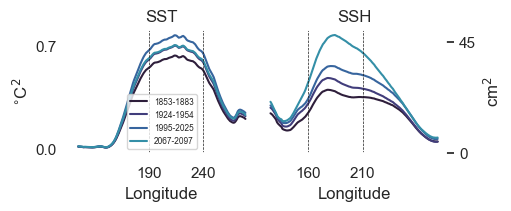

In [10]:
## time indices to plot
t0 = [1853, 1924, 1995, 2067]

## colorbar
colors = sns.color_palette("mako")

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2), layout="constrained")

for t0_, c in zip(t0, colors):

    ## get end-time
    t1_ = t0_ + 30

    ## compute variance for period
    var_t0_ = anom_ndj_recon.sel(year=slice(t0_, t1_)).var(["member", "year"])

    ## plot
    axs[0].plot(anom_ndj_recon.longitude, var_t0_["sst"], label=f"{t0_}-{t1_}", c=c)
    axs[1].plot(anom_ndj_recon.longitude, var_t0_["ssh"], label=f"{t0_}-{t1_}", c=c)

## format/label axes
label_axs(axs)
add_xticks(axs[0], [190, 240])
add_xticks(axs[1], [160, 210])

plt.show()

Same, but for Hövmöller

In [11]:
def plot_hov2(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.month,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="both",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Month")
        ax.set_xticks([1, 12])
        ax.set_yticks([])
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return

In [12]:
## Reconstruct T,h variables
T = src.utils.reconstruct_fn(
    scores=anom_rolling["sst"], components=components["sst"], fn=src.utils.get_nino34
)
h = src.utils.reconstruct_fn(
    scores=anom_rolling["ssh"], components=components["ssh"], fn=src.utils.get_nino4
)
Th = xr.merge([T.rename("T"), h.rename("h")])

## get rolling variance
Th_var = get_rolling_var(Th)

In [13]:
## Get variance by month
Th_var_bymonth = src.utils.unstack_month_and_year(Th_var)

## Look at difference from first 30 years
clim_var_bymonth = Th_var_bymonth.isel(year=slice(None, 30)).mean("year")
Th_var_bymonth = Th_var_bymonth - clim_var_bymonth

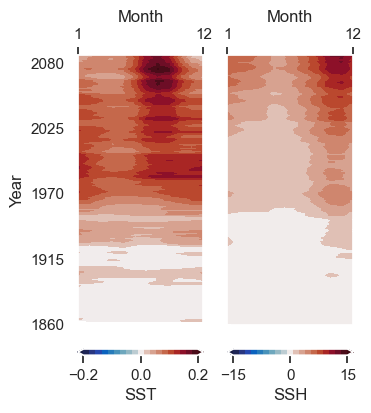

In [14]:
## setup plot
fig, axs = plt.subplots(1, 2, figsize=(3.6, 4), layout="constrained")

## plot T data
plot_hov2(axs[0], Th_var_bymonth["T"].T, amp=0.2, label=f"SST")
plot_hov2(axs[1], Th_var_bymonth["h"].T, amp=15, label=f"SSH")

axs[0].set_yticks(np.arange(1860, 2100, 55))
axs[0].set_ylabel("Year")
plt.show()

## Change in zonal gradient

### Compute zonal gradient

In [41]:
## get subset of data to look at
anom_ = anom.sel(time=slice("1979", "2024"))

## compute zonal gradient at every time step
zonal_grad = src.utils.reconstruct_fn(components, anom_, fn=get_zonal_grad)

## get monthly avg
zonal_grad_by_month = zonal_grad.groupby("time.month").mean()

### Look at forced change

In [9]:
## compute zonal gradient
zonal_grad_forced = src.utils.reconstruct_fn(components, forced, fn=get_zonal_grad)

## reshape from time -> (month, year)
reshape = lambda x: x.reshape(12, -1, order="F")
zonal_grad_forced_by_month = reshape(zonal_grad_forced["sst"].values)

## subtract clim
clim = zonal_grad_forced_by_month[:, :30].mean(1, keepdims=True)
zonal_grad_change = zonal_grad_forced_by_month - clim

## get month, year dims
month = np.unique(forced.time.dt.month.values)
year = np.unique(forced.time.dt.year)

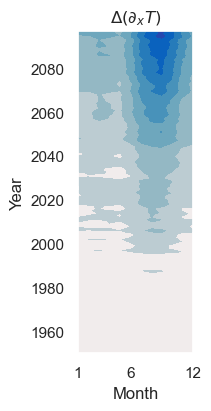

In [10]:
## setup plot
fig, ax = plt.subplots(figsize=(2, 4), layout="constrained")

## plot data
kwargs = dict(levels=src.utils.make_cb_range(1, 0.1), cmap="cmo.balance")
plot_data = ax.contourf(month, year, zonal_grad_change.T, **kwargs)

## label
ax.set_ylabel("Year")
ax.set_xlabel("Month")
ax.set_xticks([1, 6, 12])
ax.set_title(r"$\Delta \left(\partial_x T\right)$")
ax.set_ylim([1950, None])

plt.show()

## Look at mean state-dependence

### Compare Bjerknes growth rate to zonal gradient

#### Load $T,h$ data

In [11]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

#### Fit RO to $T,h$ data

In [12]:
## get subset of data
Th_sub = Th.sel(time=slice("1979", "2024"))

## initialize model
model = XRO(ncycle=12, ac_order=3, is_forward=True)

## fit to individual ensemble members
kwargs = dict(model=model, T_var="T_3", h_var="h_w", verbose=True)
_, fits = src.utils.get_RO_ensemble(Th_sub, **kwargs)

## extract parameters
params = model.get_RO_parameters(fits)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.73it/s]


#### Look at intra-ensemble spread
$\partial_x T$ vs. BJ index  
Compare to Maher et al (2023)

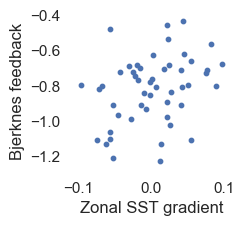

In [13]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(zonal_grad_by_month["sst"].mean("month"), params["R"].mean("cycle"), s=10)
# ax.scatter(zonal_grad_by_month.sel(month=7), params["R"].sel(cycle=7), s=10)
ax.set_xlabel("Zonal SST gradient")
ax.set_ylabel("Bjerknes feedback")
plt.show()